# Import Modules

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Load Data

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Examine the dataset 
X, y = mnist["data"], mnist["target"]
X.shape, type(X), y.shape, type(y) # each image has 784 feature, because each image is 28 x 28 pixels and each feature simply represents one pixel intensity from 0 (white) to 255 (black)

((70000, 784),
 pandas.core.frame.DataFrame,
 (70000,),
 pandas.core.series.Series)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


In [6]:
y.describe()

count     70000
unique       10
top           1
freq       7877
Name: class, dtype: object

In [7]:
# Given that label 'y' is a string, let's cast y to integer
y = y.astype(np.uint8)

# Explore some data

In [34]:
# function to randomly pick a digit and display the same

def random_digit(dataset: pd.DataFrame, target: pd.Series) -> None:
    """
    function to pick a random sample from given dataset and display the image

    Args:
        dataset: feature dataframe
        target: label series

    Retruns:
        Random digit from the given dataset
    """
    import numpy as np 
    import matplotlib.pyplot as plt 

    random_index = np.random.randint(len(dataset))
    random_digit = dataset.loc[[random_index], :]
    random_image = random_digit.to_numpy().reshape(28, 28)
    
    plt.imshow(random_image, cmap='binary')
    plt.axis('off')
    plt.show()

    print(f"Label: {target.loc[random_index]}")

    return random_digit

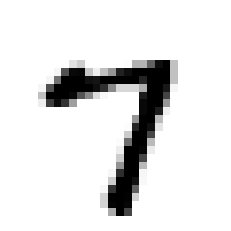

Label: 7


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
32877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# explore random digit
random_digit(X, y)

# Plot Digits

In [22]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    # print(type(image_grid))
    # print(image_grid.shape)
    # print(image_grid)

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = "binary", **options)
    plt.axis("off")

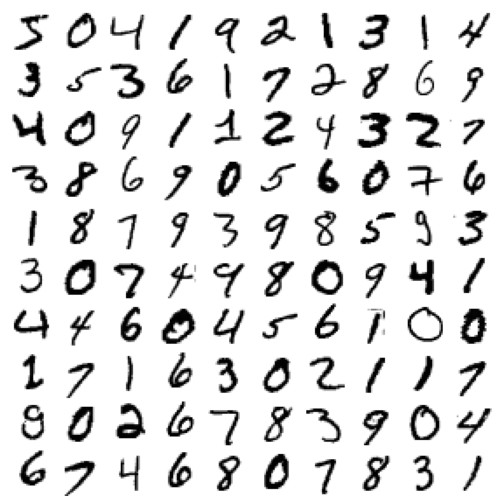

In [23]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

# Split train and test data

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y [60000:]  # MNIST dataset is already shuffled, so no need to shuffle again

# Binary Classifier

## SGD Classifier

In [ ]:
# Let's train a binary classifier for detecting digit "5" (5-detector)
# So, let's prepare the training data and labels for the same

y_train_5 = (y_train == 5)

# Let's do the same for test dataset
y_test_5 = (y_test == 5)

In [ ]:
# using SGD (Stochastic Gradient Descent) Classifer
# SGD deal with training instances independently, one at a time, which also makes SGD well suited for online learning
# SGDClassifier relies on randomness during training (hence the name "stochastic")

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

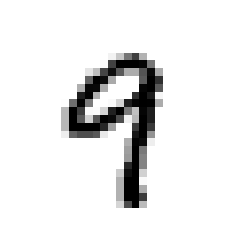

Label: False


array([False])

In [ ]:
# predict with random digit 

digit = random_digit(X_train, y_train_5)
sgd_clf.predict(digit)

## Measuring Accuracy using Cross-Validation

In [ ]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# Example of implementing the same cross-val score but with custom code

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
# Let's compare the performance with a dumb classifier that always predict it as not a digit "5"

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        return self 

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix with CV

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [ ]:
y_train_pred.shape

(60000,)

In [ ]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# Confusion matrix for perfect predictions

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [ ]:
# Precision Score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
# Recall Score
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
# F1 Score - harmonic mean of precision and recall
# Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values; 
# as a result, the classifier will only get a high F1 score if both recall and precision are high

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
# Explore the decision score for a given instance used by the SGD Classifier
y_scores = sgd_clf.decision_function(digit)
y_scores

array([-3995.90912792])

## Precision Recall Curve

In [ ]:
# Call cross_val_predict() function to get the scores of all instances in the training set

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores.shape

(60000,)

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
# function to plot precision and recall as functions of the threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid("True")
    plt.axis([-50000, 50000, 0, 1])

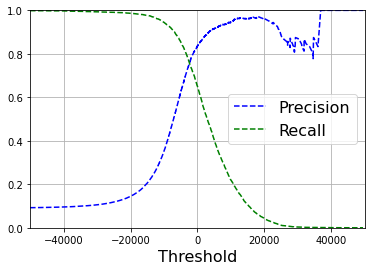

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

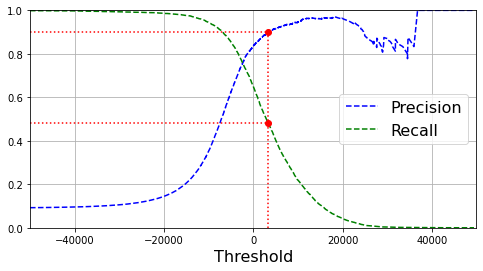

In [ ]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

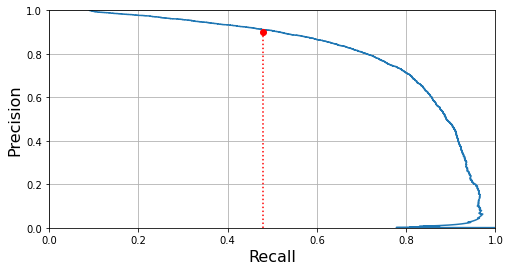

In [ ]:
# Precision versus Recall

plt.figure(figsize=(8, 4))
plt.plot(precisions, recalls)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16) 
plt.plot([recall_90_precision], [0.9], "ro")
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.axis([0, 1, 0, 1])
plt.grid("True")

## ROC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# TPR - True Positive Rate / Recall / Sensitivity
# FPR - False Positive Rate / 1 - Specificity / 1 - TNR

In [ ]:
# function to plot roc curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16) 
    plt.grid(True)

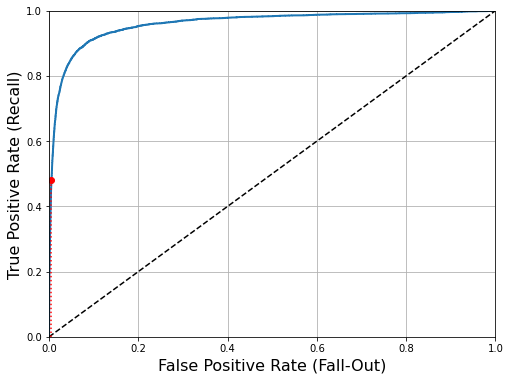

In [ ]:
plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

## ROC AUC

In [ ]:
# One way to compare classifiers is to measure the area under the curve (AUC)
# A perfect clasifier will have a ROC AUC equal to 1, where as a purely random classifier will have a ROC AUC equal to 0.5

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Random Forest Classifier

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, 
                                    X_train, 
                                    y_train_5, 
                                    cv=3, 
                                    method='predict_proba')

In [ ]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class

In [ ]:
fpr_forest, tpr_forest, thesholds_forest = roc_curve(y_train_5, y_scores_forest)

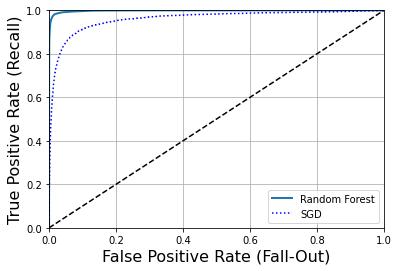

In [ ]:
# Plot ROC curve for Random Forest Classifier 

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_preds_forest = cross_val_predict(forest_clf, 
                                    X_train, 
                                    y_train_5, 
                                    cv=3)

In [ ]:
precision_score(y_train_5, y_preds_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_preds_forest)

0.8662608374838591

# Multiclass Classification

In [ ]:
# SVM Classifier

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

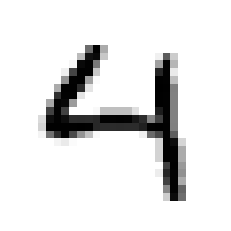

Label: 4


array([4], dtype=uint8)

In [ ]:
# predict with random digit 

digit = random_digit(X_train, y_train)
svm_clf.predict(digit)

In [ ]:
# Let's check the dcision_function for the svm_clf
some_digit_scores = svm_clf.decision_function(digit)
some_digit_scores

array([[ 1.7379906 , -0.30940303,  3.80597169,  1.73918202,  9.30691636,
         6.20950477,  1.75503054,  7.13121001,  5.09236545,  8.30309128]])

In [ ]:
# Let's examine the class
svm_clf.classes_[np.argmax(some_digit_scores)]

4

In [ ]:
# Let's train specifically OneVsRestClassifer
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [ ]:
# Let's examine the estimators
len(ovr_clf.estimators_)

10

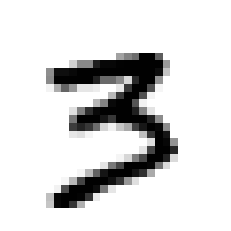

Label: 3


array([3], dtype=uint8)

In [ ]:
# Let's predict 
digit = random_digit(X_train, y_train)
ovr_clf.predict(digit)

In [11]:
# Let's train SGD Classifer
sgd_multiclass_clf = SGDClassifier()
# sgd_multiclass_clf.fit(X_train, y_train)

In [13]:
# Let's evaluate accuracy of trained SGDClassifer with cross validation
cross_val_score(sgd_multiclass_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.84115, 0.8731 , 0.8679 ])

In [14]:
# Let's work on scaled input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_multiclass_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([0.8974 , 0.8949 , 0.90635])

# Error Analysis

In [15]:
# Let's look at Confusion matrix

y_multiclass_train_pred = cross_val_predict(sgd_multiclass_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_multiclass_train_pred)

conf_mx 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([[5578,    0,   21,    7,    8,   44,   36,    5,  223,    1],
       [   0, 6404,   37,   26,    4,   43,    4,    8,  205,   11],
       [  27,   26, 5241,   92,   71,   26,   71,   38,  359,    7],
       [  24,   16,  119, 5240,    2,  204,   26,   42,  386,   72],
       [  10,   14,   47,    9, 5210,   12,   38,   27,  315,  160],
       [  27,   16,   33,  170,   52, 4461,   77,   17,  507,   61],
       [  31,   16,   45,    2,   42,   95, 5559,    3,  124,    1],
       [  20,   10,   53,   26,   49,   15,    3, 5692,  186,  211],
       [  19,   64,   46,   93,    3,  123,   25,   10, 5426,   42],
       [  23,   20,   31,   64,  116,   33,    1,  180,  368, 5113]])

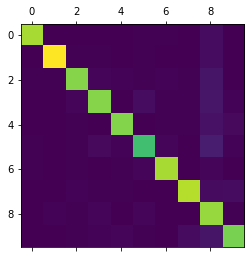

In [16]:
plt.matshow(conf_mx)

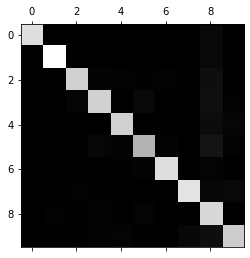

In [17]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [19]:
# Standardize the errors by output class instead of looking at absolute number of errors

row_sums = conf_mx.sum(axis=1, keepdims=True)

norm_conf_mx = conf_mx / row_sums

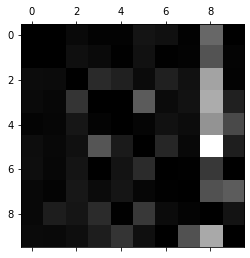

In [21]:
# Fill the diagonal with zeros to keep only the errors

np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

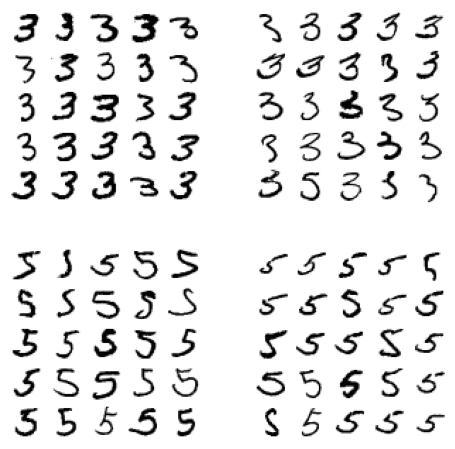

In [24]:
# Analyze 3 and 5 correct and incorrect classification samples

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_multiclass_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_multiclass_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_multiclass_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_multiclass_train_pred == cl_b)]

# plot

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification

In [26]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [30]:
y_train_large.shape, y_train_odd.shape, y_multilabel.shape

((60000,), (60000,), (60000, 2))

In [31]:
type(y_train_large), type(y_train_odd), type(y_multilabel)

(pandas.core.series.Series, pandas.core.series.Series, numpy.ndarray)

In [32]:
# Let's train KNeighborsClassifer which support multilabel classification

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

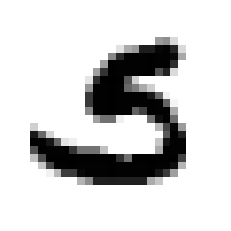

Label: 0    False
1     True
Name: 25577, dtype: bool


array([[False,  True]])

In [36]:
# Let's predict 
digit = random_digit(X_train, pd.DataFrame(y_multilabel))
knn_clf.predict(digit)

In [39]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [38]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')  

# average='macro' assumes that all labels are equal, however if that is not the case 
# and you may want to give more weight to the classifier's score, one simple option is to 
# give each label a weight equal to its support (i.e. # of instances with that target label)
# To do this, simly set average='weighted'

0.976410265560605

# Multioutput Classification

In [87]:
# let's create some dataset with MNIST images and random noise and use that to predict the original images as multioutput classification

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise 

y_train_mod = X_train
y_test_mod = X_test 

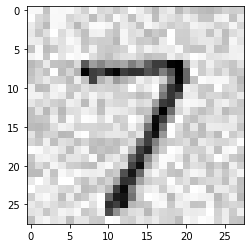

In [88]:
# Visualize one of the noisy images from our test set 
some_random_index = np.random.choice(X_test_mod.index)
some_random_digit = X_test_mod.loc[some_random_index, :]

some_random_digit_image = some_random_digit.to_numpy().reshape(28, 28)
plt.imshow(some_random_digit_image, cmap="binary")
plt.show()

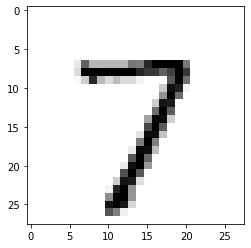

In [89]:
# Visualize the original image
original_digit = y_test_mod.loc[some_random_index, :]
original_digit_image = original_digit.to_numpy().reshape(28, 28)
plt.imshow(original_digit_image, cmap="binary")
plt.show()

In [90]:
# Train knn classsifier on noisy image data
knn_noisy_img_clf = KNeighborsClassifier()
knn_noisy_img_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [91]:
# Predict with trained knn_noisy_img_clf
clean_digit = knn_noisy_img_clf.predict(pd.DataFrame([X_test_mod.loc[some_random_index]]))

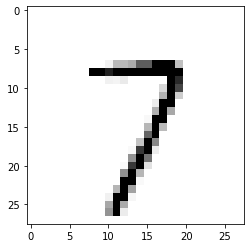

In [92]:
clean_digit_image = clean_digit.reshape(28, 28)
plt.imshow(clean_digit_image, cmap="binary")
plt.show()